In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister,ClassicalRegister
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit import transpile
from numpy import random
from collections import Counter
from qiskit.visualization import plot_histogram, array_to_latex
from latticecode import *
from KitaevToricCode import *


from scipy.optimize import curve_fit
from scipy.special import erfc




Most of the code implementing Kitaev's toric lattice can be found in [KitaevToricCode.py](KitaevToricCode.py). Explanation of the model and certain implementation details may be found in the README file of this repository.

The purpose of this notebook is to showcase the main qiskit function in [KitaevToricCode.py](KitaevToricCode.py), which outputs the required quantum circuit implementing the toric error correcting code.

---------------------------------------

Here, we can see some of the basic functionality of the main qiskit function outputing the quantum circuit 
implementing Kitaev's toric code. 

Inputting a pair of booleans, a lattice size and a probability of error, the circuit can decode to the correct logical state with relatively high probability (as long as the physical error probability is sufficiently low). 

In the below example, we prepare the logical state $| 1 0 \rangle_{L}$ in a $3 \times 3$ toric code, run it through a Pauli error channel with 5% error rate, and the circuit is able to successfully decode back to $10$ with a relatively high probability rate.

In [ ]:
x0 = 1
x1 = 1
k0 = 3
k1 = 3
p_error = 0.00
LatticeCircuit = KitaevToricModel(x0, x1, k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=100, memory=True)
result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )


11 0000000000000000000000000000000000000000000000000
No logical error has been observed


The first two bits are the readout of the measurement of the data qubits in the logical $Z$-basis. The last register are the syndrome qubits. Even if they are not reset at the end of the circuit, the first $2$ bits are what we use to decode the logical state.

--------------------------------


In the next example, we prepare the logical state $|11\rangle_{L}$ in a $4 \times 4$ toric code, run it through a Pauli error channel with 7% error rate, and the circuit is able to decode back to the appropriate logical state with relatively high probability.

In [4]:
x0 = 1
x1 = 1
k0 = 3
k1 = 3
p_error = 0.07
LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=100, memory=True)
result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )

11 000000000
No logical error has been observed


------------------------


In the next example, we prepare the logical state $| 11 \rangle_{L}$ in $3 \times 3$ toric code, and run it through an error channel with a higher error rate of 15% and see that the circuit has a harder time decoding back to the appropriate logical state.

In [12]:
x0 = 1
x1 = 1
k0 = 3
k1 = 3
p_error = 0.15
LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=100, memory=True)
result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )

01 100110100


However, repeating the above on a larger lattice ($5 \times 5$), gives us a better probability of decoding to the appropriate logical state. 

In [14]:
x0 = 1
x1 = 1
k0 = 5
k1 = 5
p_error = 0.15
LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=100, memory=True)
result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )

11 0011000110100101000000100
No logical error has been observed


-----------------------

We write a helper function for running a number of simulations in order to extract some experimental/statistical data about the toric code.

In [15]:


def execute_model(x_0,x_1, k0,k1 , p_error, num_shots, success=True):
    success_rate = 0
    for i in range(num_shots):
        LatticeCircuit = KitaevToricModel(x_0, x_1, k0,k1, p_error, error=True)

        job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)
        result = job.result()
        memory = result.get_memory(LatticeCircuit)

        memory_result = memory[0]
        if memory_result[0:2] == str(x_0) + str(x_1):
            success_rate += 1     
            
    if success == True:      
        return  success_rate/num_shots
    
    if success == False:
        return 1 - (success_rate/num_shots) 

        


Here, we see that the success rate of decoding to the correct logical state goes down as the rate of physical error goes up. Recall that if enough physical errors occur, then the syndrome recovery procedure may accumulate enough bit/phase flips as to cause a logical error.


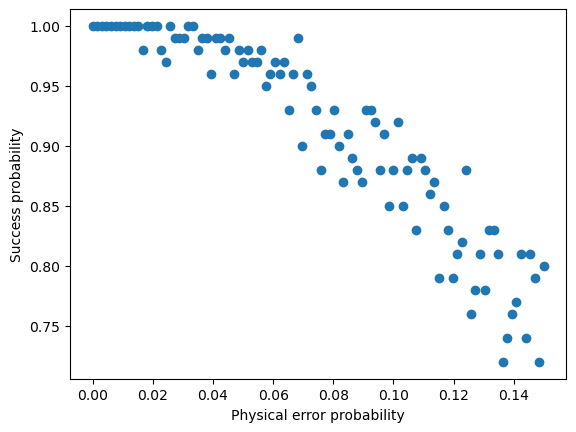

In [16]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.linspace(0, 0.15, 100)


success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
plt.scatter(error_rates, success_rates_3x3, label='k = 3' )


plt.ylabel("Success probability")
plt.xlabel("Physical error probability")
plt.show()

We may also compare logical error rates v.s. physical error rates for a certain number of samples and shots. We use a statistical fit in order to interpret the noisy data (alternatively, we could just take a better sample..)



The code below generates some plots, visualizing the relationship between logical error rates and physical errors. We use the examples of $k=3,5,7$.  

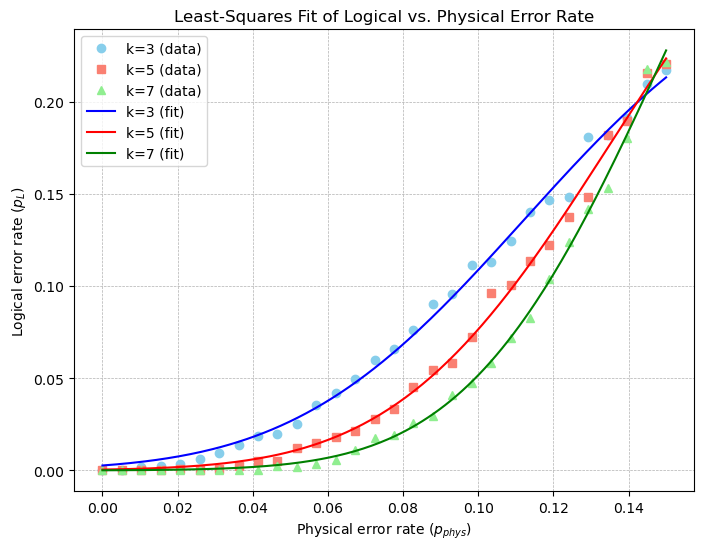

In [3]:

error_rates = np.linspace(0, 0.15, 30)

x_0 , x_1 = 0,0
logical_error_rates_7x7 = [execute_model(x_0, x_1, 7, 7, p, 3000, success=False) for p in error_rates]
logical_error_rates_5x5 = [execute_model(x_0, x_1, 5, 5, p, 3000, success=False) for p in error_rates]
logical_error_rates_3x3 = [execute_model(x_0, x_1, 3, 3, p, 3000, success=False) for p in error_rates]

def threshold_fit_function(p, A, p_th, sigma):
    """
    p: physical error rate (x-axis)
    A: amplitude/scaling factor
    p_th: threshold location
    sigma: width/steepness of the transition
    """
    return A * 0.5 * erfc((p_th - p) / sigma)



params_3, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_3x3, p0=[1.0, 0.1, 0.02])
params_5, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_5x5, p0=[1.0, 0.1, 0.02])
params_7, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_7x7, p0=[1.0, 0.1, 0.02])

# --- Generate smooth curves using the fitted parameters ---
x_fit = np.linspace(0, 0.15, 200)
y_fit_3 = threshold_fit_function(x_fit, *params_3)
y_fit_5 = threshold_fit_function(x_fit, *params_5)
y_fit_7 = threshold_fit_function(x_fit, *params_7)

plt.figure(figsize=(8, 6))

# Plot the raw data points
plt.plot(error_rates, logical_error_rates_3x3, 'o', color='skyblue', label='k=3 (data)')
plt.plot(error_rates, logical_error_rates_5x5, 's', color='salmon', label='k=5 (data)')
plt.plot(error_rates, logical_error_rates_7x7, '^', color='lightgreen', label='k=7 (data)')

# Plot the fitted curves
plt.plot(x_fit, y_fit_3, color='blue', label='k=3 (fit)')
plt.plot(x_fit, y_fit_5, color='red', label='k=5 (fit)')
plt.plot(x_fit, y_fit_7, color='green', label='k=7 (fit)')

plt.title('Least-Squares Fit of Logical vs. Physical Error Rate')
plt.xlabel('Physical error rate ($p_{phys}$)')
plt.ylabel('Logical error rate ($p_L$)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

While it may be difficult to pinpoint exactly what the code threshold is, we clearly see that there is some sort of ``phase transition" happening around the 14% physical error rate region. After this point, it seems disadvantageous to have a larger lattice or longer code distance, given the high rate of physical error